In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import os
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil

Categorize data

In [2]:
train = pd.read_csv('train.csv')

train[['image_id', 'category']]

,image_id,category
0,0,77
1,1,81
2,2,52
3,3,72
4,4,58
...,...,...
18535,18535,22
18536,18536,91
18537,18537,78
18538,18538,74


In [3]:
if not os.path.exists("dataset"):
        os.makedirs("dataset")

for index, row in train.iterrows():
    if not os.path.exists("dataset/"+str(row['category'])):
        os.makedirs("dataset/"+str(row['category']))
    shutil.copyfile("train/"+str(row['image_id'])+".jpg", "dataset/"+str(row['category'])+"/"+str(row['image_id'])+".jpg")

In [4]:
import pathlib
data_dir = "dataset"
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

18540


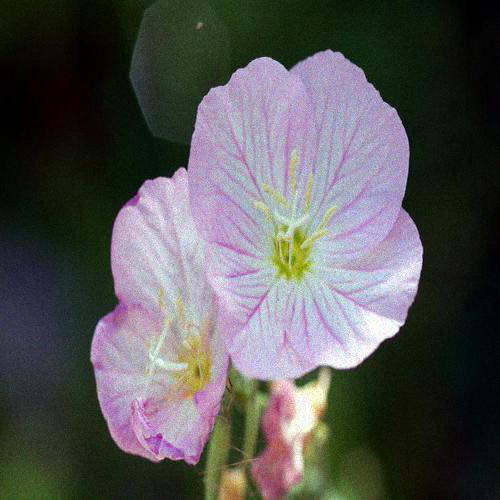

In [6]:
folder1 = list(data_dir.glob('1/*'))
PIL.Image.open(str(folder1[0]))

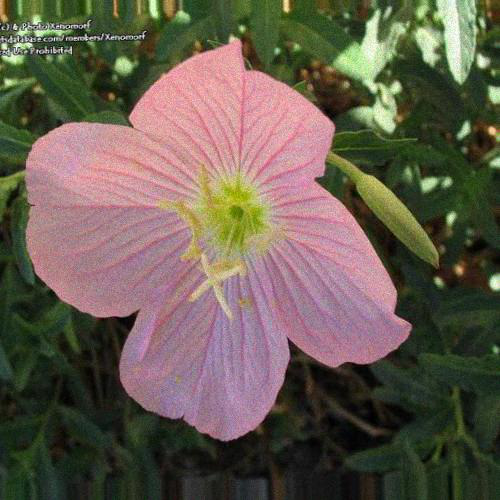

In [7]:
PIL.Image.open(str(folder1[6]))

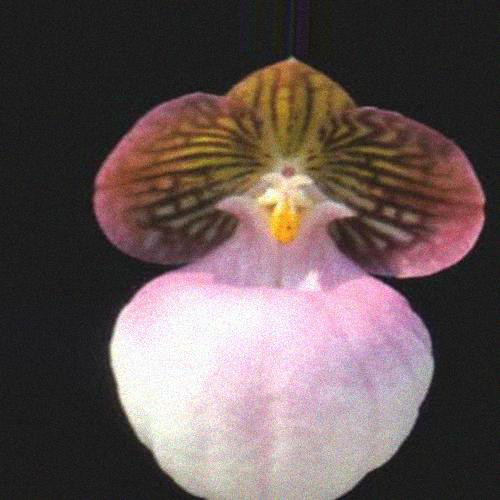

In [8]:
folder2 = list(data_dir.glob('2/*'))
PIL.Image.open(str(folder2[0]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18540 files belonging to 102 classes.
Using 14832 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18540 files belonging to 102 classes.
Using 3708 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


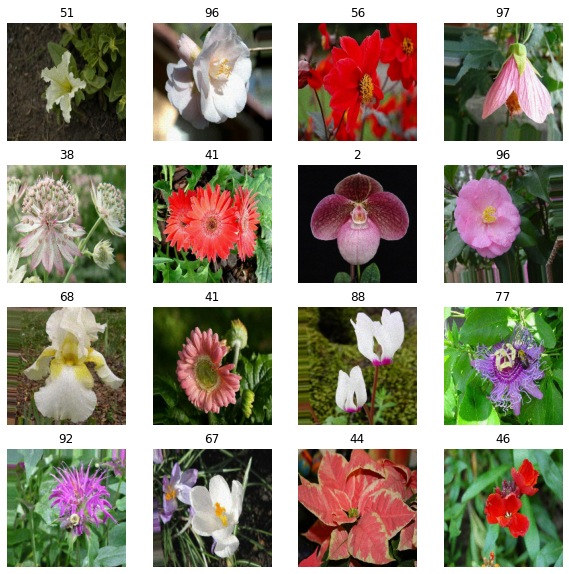

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.9984996


In [18]:
num_classes = 102

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [21]:
epochs=10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
464/464 [==============================] - 168s 361ms/step - loss: 3.4010 - accuracy: 0.1934 - val_loss: 2.6155 - val_accuracy: 0.3285
Epoch 2/10
464/464 [==============================] - 136s 294ms/step - loss: 2.0131 - accuracy: 0.4701 - val_loss: 1.9782 - val_accuracy: 0.4768
Epoch 3/10
464/464 [==============================] - 142s 306ms/step - loss: 1.1083 - accuracy: 0.6853 - val_loss: 1.7326 - val_accuracy: 0.5477
Epoch 4/10
464/464 [==============================] - 148s 319ms/step - loss: 0.4791 - accuracy: 0.8603 - val_loss: 2.0711 - val_accuracy: 0.5367
Epoch 5/10
464/464 [==============================] - 164s 354ms/step - loss: 0.1977 - accuracy: 0.9407 - val_loss: 2.3046 - val_accuracy: 0.5510
Epoch 6/10
464/464 [==============================] - 142s 305ms/step - loss: 0.1014 - accuracy: 0.9694 - val_loss: 2.6337 - val_accuracy: 0.5445
Epoch 7/10
464/464 [==============================] - 137s 294ms/step - loss: 0.0861 - accuracy: 0.9737 - val_loss: 2.9213 -

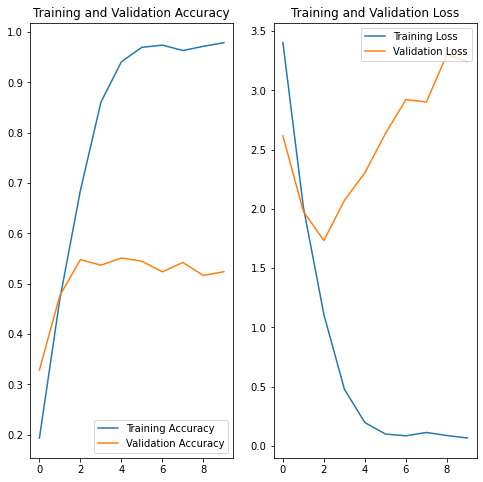

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Over fitting can be seen here as training is increasing overtime but validation accuracy stops around 50-60%, So we perform data agumentation

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

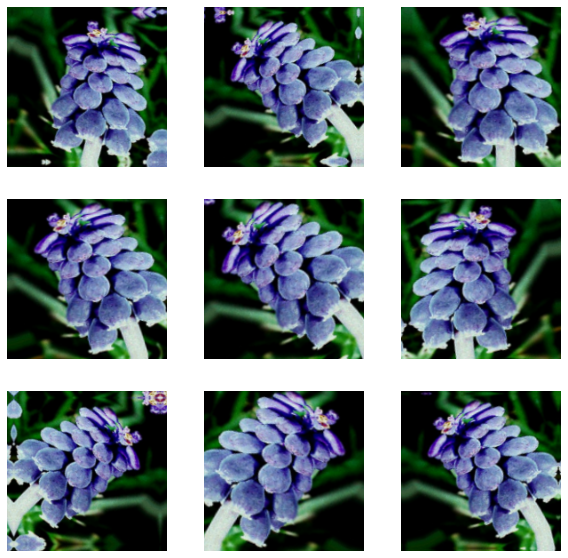

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
464/464 [==============================] - 161s 347ms/step - loss: 3.6408 - accuracy: 0.1405 - val_loss: 3.0360 - val_accuracy: 0.2279
Epoch 2/15
464/464 [==============================] - 158s 340ms/step - loss: 2.6558 - accuracy: 0.3143 - val_loss: 2.4361 - val_accuracy: 0.3662
Epoch 3/15
464/464 [==============================] - 160s 345ms/step - loss: 2.1211 - accuracy: 0.4349 - val_loss: 2.1124 - val_accuracy: 0.4355
Epoch 4/15
464/464 [==============================] - 160s 344ms/step - loss: 1.7777 - accuracy: 0.5166 - val_loss: 1.7816 - val_accuracy: 0.5227
Epoch 5/15
464/464 [==============================] - 157s 339ms/step - loss: 1.5242 - accuracy: 0.5730 - val_loss: 1.5881 - val_accuracy: 0.5712
Epoch 6/15
464/464 [==============================] - 158s 340ms/step - loss: 1.3473 - accuracy: 0.6202 - val_loss: 1.4722 - val_accuracy: 0.6011
Epoch 7/15
464/464 [==============================] - 157s 338ms/step - loss: 1.2036 - accuracy: 0.6564 - val_loss: 1.4322 -

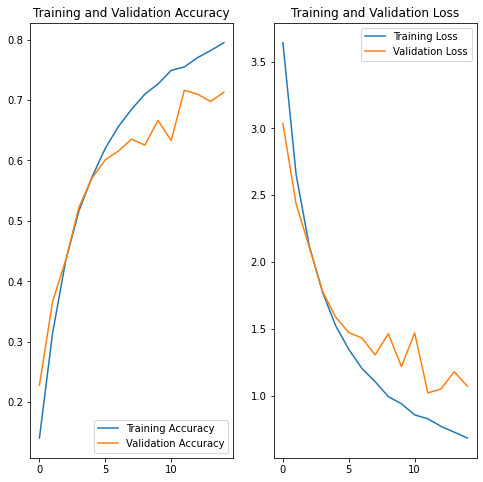

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
test = pd.read_csv('test.csv')
for index, row in test.iterrows():
    img = keras.preprocessing.image.load_img("test/"+str(int(row['image_id']))+".jpg", target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    test.loc[index, 'category'] = class_names[np.argmax(score)]
    test.loc[index, 'percentage'] = 100 * np.max(score)
    test.to_csv("test.csv", index=False)